In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

matplotlib.rcParams['figure.figsize'] = [16, 4]
pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('dfTimeSeries_Example1.csv')

In [3]:
df.head(3)

,dept_id,state_id,cat_id,d,date,event_name_1,event_type_1,value_sales,sell_price
0,FOODS_1,CA,FOODS,d_1,2011-01-29,NaN,NaN,297,2.989109
1,FOODS_1,CA,FOODS,d_10,2011-02-07,NaN,NaN,176,3.016636
2,FOODS_1,CA,FOODS,d_100,2011-05-08,Mother's day,Cultural,211,2.987851


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13391 entries, 0 to 13390
Data columns (total 9 columns):
dept_id         13391 non-null object
state_id        13391 non-null object
cat_id          13391 non-null object
d               13391 non-null object
date            13391 non-null object
event_name_1    1078 non-null object
event_type_1    1078 non-null object
value_sales     13391 non-null int64
sell_price      13391 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 941.7+ KB


In [5]:
df['date'] = pd.to_datetime(df.date)
df = df[df['date'] >= '2014-01-01']

In [6]:
print(df.dept_id.unique())
lista_itens = df.dept_id.unique()

#Filtrando apenas uma série
df_item1 = df.loc[df['dept_id'] == 'HOBBIES_1', : ]
#Coloca o index como a data
df_item1.index = df_item1.date
df_item2 = df.loc[df['dept_id'] == 'HOUSEHOLD_1', : ].set_index('date')

df_item1.head()

print(df_item1.shape)
print(df.shape)

['FOODS_1' 'FOODS_2' 'FOODS_3' 'HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1'
 'HOUSEHOLD_2']
(845, 9)
(5915, 9)


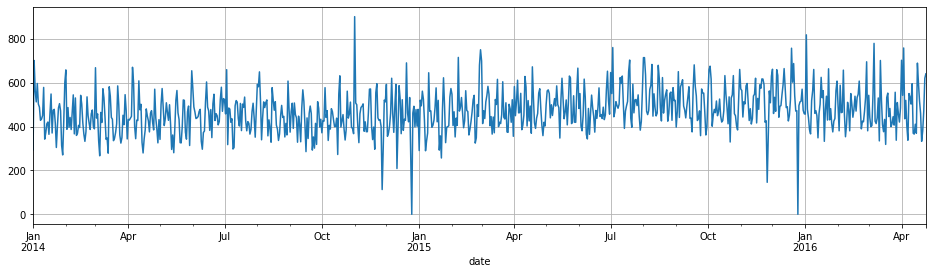

In [7]:
df_item1['value_sales'].plot(grid = True)

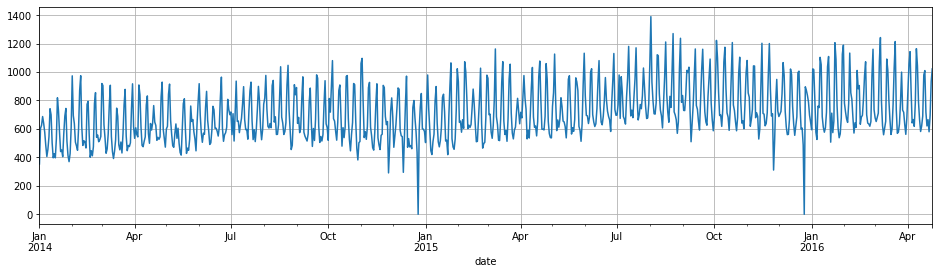

In [8]:
df_item2['value_sales'].plot(grid = True)

# 1º Conceito - Correlação entre duas séries

Por vezes, é bem comum que duas séries variem conjuntamente. Ou seja, quando uma tem um incremento, a outra sobe também. Nesse caso, o mesmo acontece quando uma das duas séries tem queda.

Correlação de vendas entre as duas séries:  67.0 %


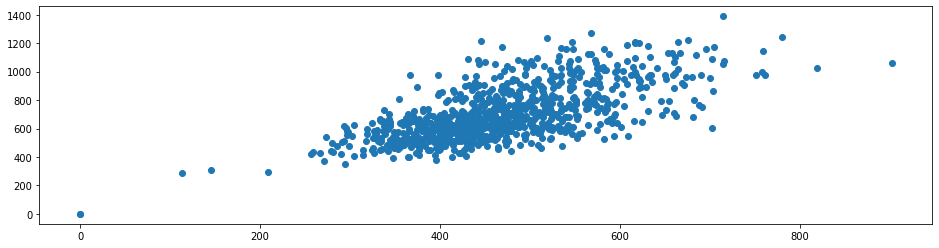

In [8]:
correlacao = df_item1['value_sales'].corr(df_item2['value_sales'])
print("Correlação de vendas entre as duas séries: ", np.round(correlacao*100), "%" ) 
plt.scatter(df_item1['value_sales'], df_item2['value_sales'])
plt.show()


$\rho  = 1 $ Correlação Totalmente Positiva

$\rho  = -1 $ Correlação Totalmente Negativa

$\rho = 0 $ Sem Correlação




Nem toda correlação entre duas séries significa necessariamente que elas são correlatas... https://www.tylervigen.com/spurious-correlations

Por isso, ao ver correlação entre duas séries, não devemos ver apenas os níveis, mas sim os retornos

In [15]:
diffs_dfitem1 = df_item1.loc[:,['value_sales']].diff().dropna()
diffs_dfitem1 = diffs_dfitem1[diffs_dfitem1['value_sales'] < float('inf') ]

diffs_dfitem2 = df_item2.loc[:,['value_sales']].diff().dropna()
diffs_dfitem2 = diffs_dfitem2[diffs_dfitem2['value_sales'] < float('inf') ]

In [16]:
correlacao = diffs_dfitem1['value_sales'].corr(diffs_dfitem2['value_sales'])
print("Correlação de vendas entre as diferenças das duas séries: ", np.round(correlacao*100), "%" ) 


Correlação de vendas entre as diferenças das duas séries:  53.0 %


# 2º Conceito - Autocorrelação e Autocorrelação Parcial

A autocorrelação de uma série, nada mais é do que a correlação de uma série temporal com uma cópia 'atrasada' de si mesma.

In [14]:
#Lag 1 = Venda de ontem
df_item1.loc[:,'lag1_sales'] = df_item1.value_sales.shift(1)
df_item1.loc[:,['dept_id','value_sales','lag1_sales']].head(5)

,dept_id,value_sales,lag1_sales
date,,,
2014-01-01,HOBBIES_1,294,NaN
2014-01-02,HOBBIES_1,702,294.0
2014-01-03,HOBBIES_1,565,702.0
2014-01-04,HOBBIES_1,513,565.0
2014-01-05,HOBBIES_1,597,513.0


In [20]:
autocorrelation = df_item2['value_sales'].autocorr()

print("A autocorrelação das vendas diárias com lag 1 é de " + str(np.round(autocorrelation*100)) + "%" )

A autocorrelação das vendas diárias com lag 1 é de 54.0%


Em ações, muitas estratégias de fundos multimercado são baseadas em autocorrelação dos retornos

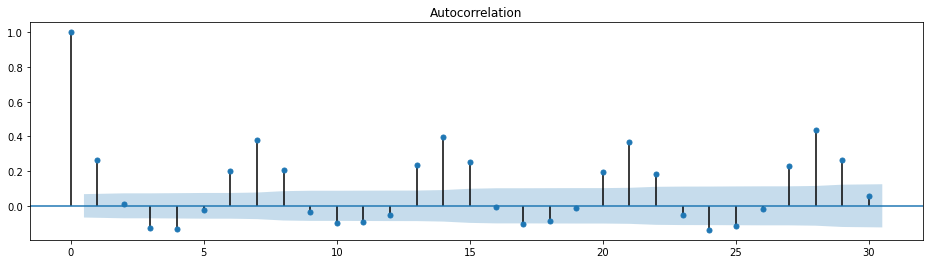

In [22]:
plot_acf(df_item1['value_sales'], alpha = 0.05);

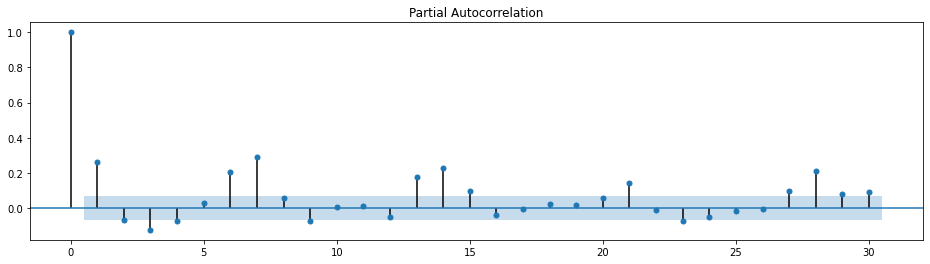

In [23]:
plot_pacf(df_item1['value_sales'], alpha = 0.05);

In [ ]:
#df.resample(rule = 'W').last()

 Muitas vezes, em séries temporais, variações diárias são improváveis de dizer o que irá acontecer amanhã, mas um movimento mais agregado no nível semana ou mês pode lhe dar uma pista sobre para onde está caminhando.

# 3º Conceito - Séries imprevisiveis (Rúido-branco e Random-Walk)


A definição de Ruído branco, é dada por 
* Média Constante através do Tempo
* Desvio Constante através do tempo
* 0 autocorrelação

#### Lembrar: Não ter autocorrelação não significa não ser previsivel, precisa ter os 3 conceitos alinhados

<Figure size 1152x288 with 0 Axes>

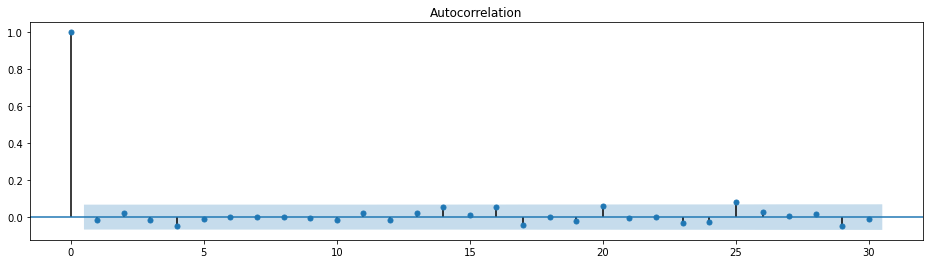

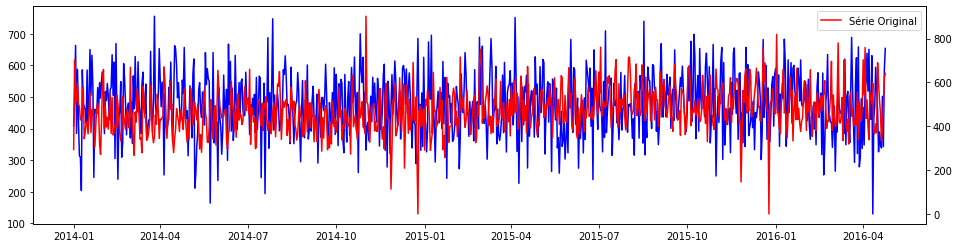

In [24]:
#Média e desvio padrão da série 1
mean_item1 = df_item1['value_sales'].mean()
std_item1 = df_item1['value_sales'].std()
ruido = np.random.normal(mean_item1, std_item1, df_item1.shape[0])
plt.clf()
plot_acf(ruido)

#As duas séries no gráfico - Ruido e Série original
fig, ax = plt.subplots()
ax.plot(df_item1.index, ruido, color='blue')
ax2 = ax.twinx()
ax2.plot(df_item1.index, df_item1["value_sales"], color='red',label='Série Original')
plt.legend()
plt.show()

# 4º Conceito - Estacionariedade 

Em termos práticos, uma série estacionária é definida como aquela sem tendencia e sem sazonalidade.
Em termos formais, uma série estacionaria tem a distribuição invariada de acordo com o tempo. Ou seja, as propriedas estatísticas da série não mudam conforme o tempo.

Isso deve ser levado em consideração, pois, caso a série NÃO seja estacionária, teremos mais parametros para estimar.

Alguns parametros como sazonalidade podem ser mais facilmente controlados em ML, outros, como a tendência podem ser mais dificeis para o modelo entender

Para identificar estacionariedade, existem duas maneiras (complementares):
 *  Gráfico da Série
 *  Teste de Raíz unitária (teste de Dickey-Fuller aumentado)

#### Exemplos de Séries estácionárias (b, g) e não-estacionárias (demais): 
<img src="img/stationary-1.png" width="800" height="400">
Fonte: Hyndman (2018) https://otexts.com/fpp2/stationarity.html

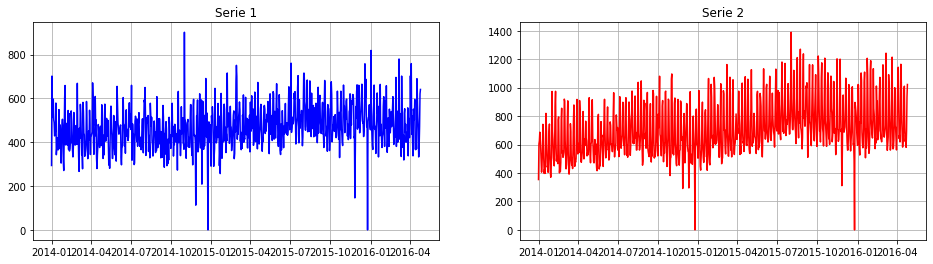

In [28]:
fig, ax = plt.subplots(1,2)
ax[0].plot(df_item1.index, df_item1.value_sales, color='blue')
ax[0].grid()
ax[0].set_title('Serie 1')

ax[1].plot(df_item2.index, df_item2.value_sales, color='red')
ax[1].grid()
ax[1].set_title('Serie 2')

plt.show()

In [30]:
adfuller_serie_1 = adfuller(df_item1.value_sales)
adfuller_serie_2 = adfuller(df_item2.value_sales)
print('p-valor do Teste aumentado de Dickey-Fuller para série 1: {0:.2f}'.format(np.round(adfuller_serie_1[1],2))) 
print('p-valor do Teste aumentado de Dickey-Fuller para série 2: {0:.2f}'.format(np.round(adfuller_serie_2[1],2)))

p-valor do Teste aumentado de Dickey-Fuller para série 1: 0.06
p-valor do Teste aumentado de Dickey-Fuller para série 2: 0.26


In [38]:
df_item1.loc[:,'diff_sales'] = df_item1.loc[:,'value_sales'].diff()
df_item2.loc[:,'diff_sales'] = df_item2.loc[:,'value_sales'].diff()

df_item1.head()

,dept_id,state_id,cat_id,d,date,event_name_1,event_type_1,value_sales,sell_price,diff_item1,diff_sales
date,,,,,,,,,,,
2014-01-01,HOBBIES_1,CA,HOBBIES,d_1069,2014-01-01,NewYear,National,294,6.333581,NaN,NaN
2014-01-02,HOBBIES_1,CA,HOBBIES,d_1070,2014-01-02,NaN,NaN,702,6.333581,408.0,408.0
2014-01-03,HOBBIES_1,CA,HOBBIES,d_1071,2014-01-03,NaN,NaN,565,6.333581,-137.0,-137.0
2014-01-04,HOBBIES_1,CA,HOBBIES,d_1072,2014-01-04,NaN,NaN,513,6.380265,-52.0,-52.0
2014-01-05,HOBBIES_1,CA,HOBBIES,d_1073,2014-01-05,NaN,NaN,597,6.380265,84.0,84.0


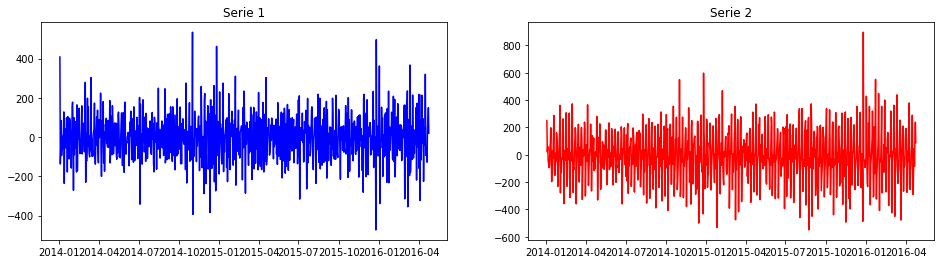

p-valor do Teste aumentado de Dickey-Fuller para série 1: 0.00
p-valor do Teste aumentado de Dickey-Fuller para série 1: 0.00


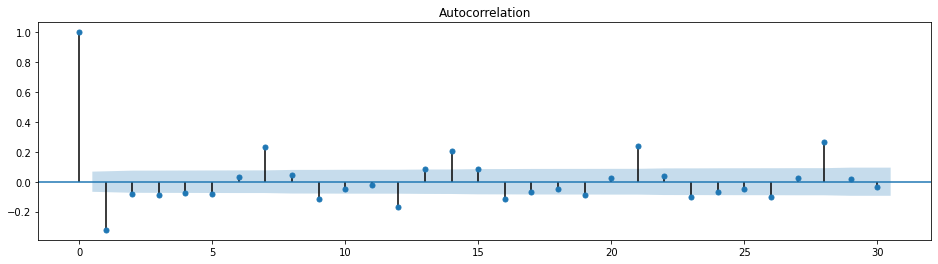

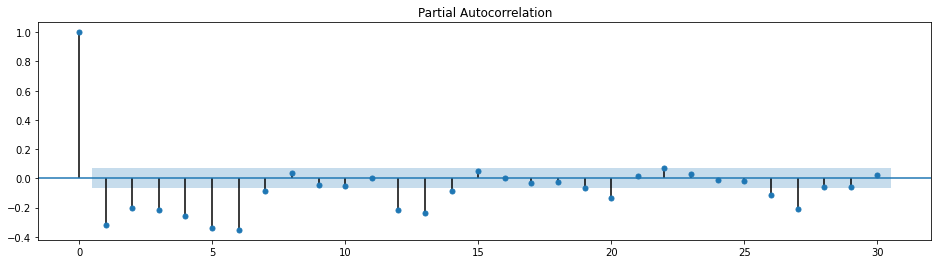

In [39]:
fig, ax = plt.subplots(1,2)
ax[0].plot(df_item1.index, df_item1.diff_sales, color='blue')
ax[0].set_title('Serie 1')

ax[1].plot(df_item2.index, df_item2.diff_sales, color='red')
ax[1].set_title('Serie 2')

plt.show()


adfuller_serie_1 = adfuller(df_item1.diff_sales.dropna())
adfuller_serie_2 = adfuller(df_item2.diff_sales.dropna())
print('p-valor do Teste aumentado de Dickey-Fuller para série 1: {0:.2f}'.format(np.round(adfuller_serie_1[1],2))) 
print('p-valor do Teste aumentado de Dickey-Fuller para série 1: {0:.2f}'.format(np.round(adfuller_serie_2[1],2))) 

plot_acf(df_item1.diff_sales.dropna(), alpha = 0.05);
plot_pacf(df_item1.diff_sales.dropna(), alpha = 0.05);

# Um último ponto... Validação e Backtest

Métodos muito comuns para avaliar modelos, são o cross-validation ou o leave-one-out.

Porém, esses métodos, ignoram o conceito temporal do Time Series. Dessa forma, caso optemos pelo cross-validation por exemplo, em alguns momentos teremos dados do futuro prevendo o dado do passado.

#### Exemplo de Cross-Validation (NÃO deve ser usado em TS):
<img src="img/TenFoldCV.png" width="800" height="400">

fonte: https://www.researchgate.net/figure/Ten-fold-cross-validation-diagram-The-dataset-was-divided-into-ten-parts-and-nine-of_fig1_326465007

Por isso, para treino e otimização da série temporal, devemos validar através de hold-out respeitando o conceito temporal.

#### Exemplo de validação Hold Out, respeitando o conceito temporal:
<img src="img/hold-out_temporal.png" width="800" height="400">

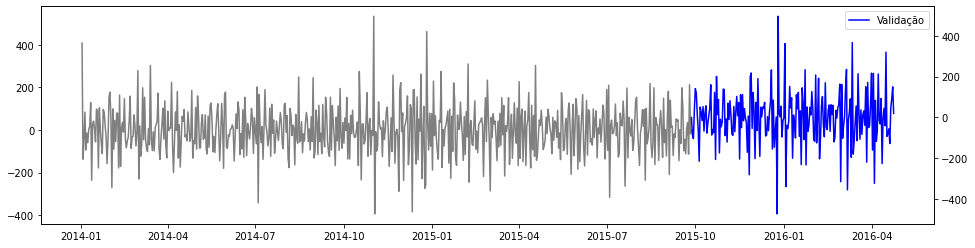

In [45]:
backtest_size = 0.75
train = df_item1.drop(['date'],axis=1).reset_index().loc[0:np.round(df_item1.shape[0]*backtest_size),:]
test = df_item1.drop(['date'],axis=1).reset_index().loc[np.round(df_item1.shape[0]*backtest_size):,:]

#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import TimeSeriesSplit


fig, ax = plt.subplots()
ax.plot(train.date, train.diff_sales, color='gray')
ax2 = ax.twinx()
ax2.plot(test.date, test.diff_sales, color='blue',label='Validação')
plt.legend()
plt.show()

# Enfim... Ajustando o modelo

Agora, iremos aplicar todos esses conceitos de série temporal, em um modelo de série temporal chamado *ARIMA (p,d,q)* (autoregressive integrated moving average).

Na literatura, podem ser encontrados outros, tais como
* Suavização Exponencial
* Holt-Winters
* SARIMA, SARIMAX (Derivações do ARIMA)

Porém, também podemos ajustar - respeitando os conceitos vistos de série temporal - em modelos regressores comuns, tais como:
* Árvores de Decisão (RandomForest, XGBoosting)
* Redes neurais simples (MLP)
* Regressões
* Support Vector Machine (SVM)

Ou até em modelos robustos que tem tal intuito, tal como o *Redes neurais com arquitetura LSTM (Long Short Term Memory)*, também utilizada para processamento de linguagem natural

#### ARIMA
definido pelas ordens: AR (q), I (d) e MA (q) + Erro advindo do ruído da série. 

Um ARIMA definido por (1, 0, 1) é dado por:

\begin{equation*}
\ Y_t = \mu +  \phi Y_{t-1} + \theta Y_{t-1} + \epsilon_t 
\end{equation*}

In [46]:
from statsmodels.tsa.arima_model import ARIMA

In [47]:
train.head()
train.index = train['date']

In [48]:
#order = AR (ar), I (d), MA (q) 
mod = ARIMA(train.diff_sales.dropna(), order=(6,0,1))
#mod = ARIMA(train.value_sales.dropna(), order=(6,1,1))

result = mod.fit()

print(result.summary())
print(result.params)
predito_AR1 = result.predict(start = test.date.min(), end = test.date.max() )

/home/lucasmarchioro/anaconda3/envs/lvmenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                              ARMA Model Results                              
Dep. Variable:             diff_sales   No. Observations:                  634
Model:                     ARMA(6, 1)   Log Likelihood               -3722.260
Method:                       css-mle   S.D. of innovations             85.648
Date:                Fri, 26 Jun 2020   AIC                           7462.520
Time:                        19:03:03   BIC                           7502.589
Sample:                    01-02-2014   HQIC                          7478.079
                         - 09-27-2015                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0327      0.629     -0.052      0.959      -1.266       1.200
ar.L1.diff_sales    -0.4804      0.088     -5.432      0.000      -0.654      -0.307
ar.L2.diff_sales    -0.5655 

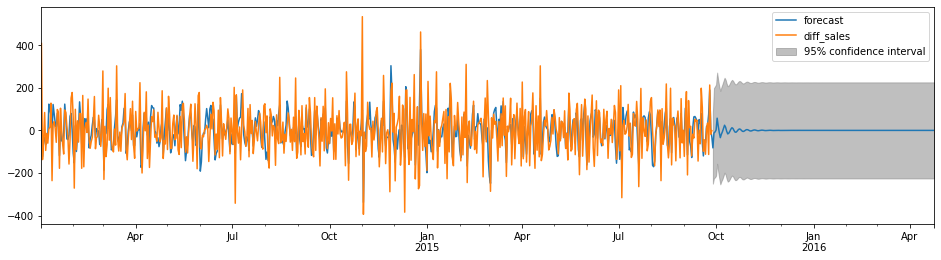

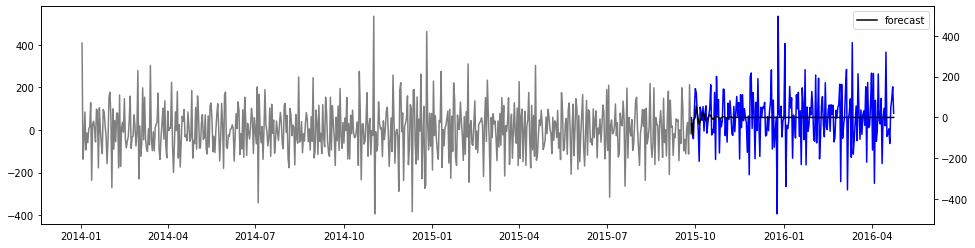

In [22]:
result.plot_predict(start = '2014-01-02', end = test.date.max() );
fig, ax = plt.subplots()
ax.plot(train.date, train.diff_sales, color='gray')
ax2 = ax.twinx()
ax2.plot(test.date, test.diff_sales, color='blue')
ax2.plot(test.date, predito_AR1, color='black',label='forecast')

plt.legend()
plt.show()

p-valor do Teste aumentado de Dickey-Fuller para o residuo do modelo: 0.00


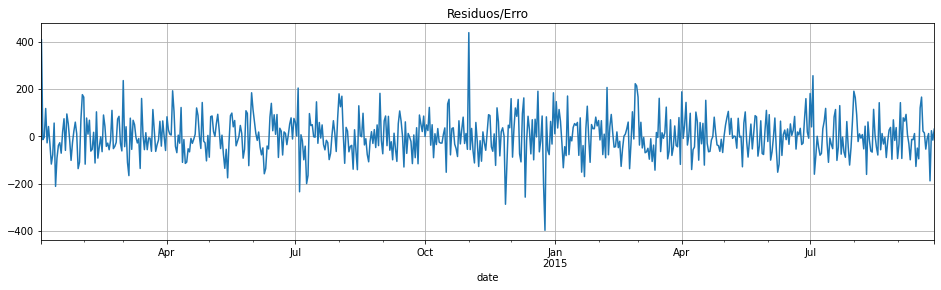

In [23]:
result.resid.plot(grid = True, title  = 'Residuos/Erro')
adfuller_residuo = adfuller(result.resid)
print('p-valor do Teste aumentado de Dickey-Fuller para o residuo do modelo: {0:.2f}'.format(np.round(adfuller_residuo[1],2))) 


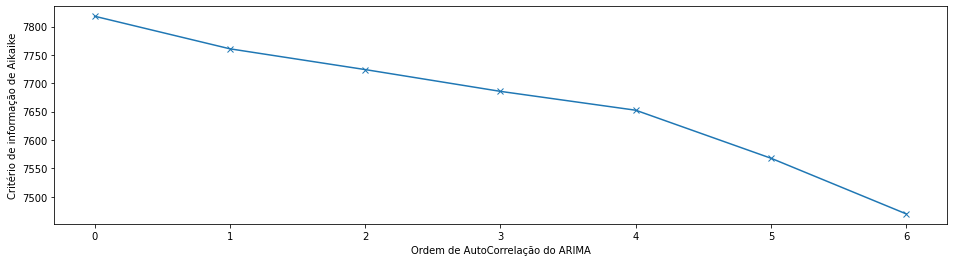

In [49]:
AIC = np.zeros(7)

train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)
for p in range(7):
    try:
        mod = ARIMA(train.value_sales.dropna(), order=(p,1,0))
        res = mod.fit()
        AIC[p] = res.aic
    except:
        pass
    
plt.plot(range(len(AIC)), AIC, marker='x')
plt.xlabel('Ordem de AutoCorrelação do ARIMA')
plt.ylabel('Critério de informação de Aikaike')
plt.show()

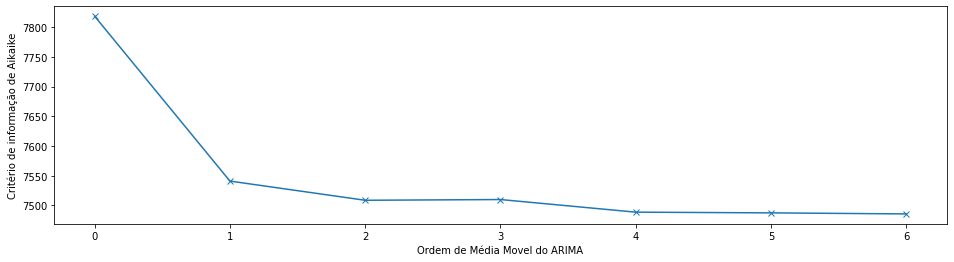

In [50]:
AIC = np.zeros(7)

for q in range(7):
    try:
        mod = ARIMA(train.value_sales.dropna(), order=(0,1,q))
        res = mod.fit()
        AIC[q] = res.aic
    except:
        pass
    
plt.plot(range(len(AIC)), AIC, marker='x')
plt.xlabel('Ordem de Média Movel do ARIMA')
plt.ylabel('Critério de informação de Aikaike')
plt.show()

Para efeitos de comparação, rodaremos uma RandomForest (s/ grid, com parametros já encontrados no ARIMA

In [53]:
#Random Forest
#Cria as variáveis
df_item1.loc[:,'weekday'] = df_item1.index.dayofweek
df_item1.loc[:,'Evento_Flag'] = np.where(df_item1['event_name_1'].isna(), 0, 1)
df_item1.loc[:,'lag_diff_sales_1'] = df_item1.loc[:,'diff_sales'].diff(1)
df_item1.loc[:,'lag_diff_sales_2'] = df_item1.loc[:,'diff_sales'].diff(2)
df_item1.loc[:,'lag_diff_sales_3'] = df_item1.loc[:,'diff_sales'].diff(3)
df_item1.loc[:,'lag_diff_sales_4'] = df_item1.loc[:,'diff_sales'].diff(4)
df_item1.loc[:,'lag_diff_sales_5'] = df_item1.loc[:,'diff_sales'].diff(5)
df_item1.loc[:,'lag_diff_sales_6'] = df_item1.loc[:,'diff_sales'].diff(6)


/home/lucasmarchioro/.local/lib/python3.8/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/lucasmarchioro/.local/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [54]:
df_item1.head()

,dept_id,state_id,cat_id,d,date,event_name_1,event_type_1,value_sales,sell_price,diff_item1,diff_sales,weekday,Evento_Flag,lag_diff_sales_1,lag_diff_sales_2,lag_diff_sales_3,lag_diff_sales_4,lag_diff_sales_5,lag_diff_sales_6
date,,,,,,,,,,,,,,,,,,,
2014-01-01,HOBBIES_1,CA,HOBBIES,d_1069,2014-01-01,NewYear,National,294,6.333581,NaN,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,HOBBIES_1,CA,HOBBIES,d_1070,2014-01-02,NaN,NaN,702,6.333581,408.0,408.0,3,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,HOBBIES_1,CA,HOBBIES,d_1071,2014-01-03,NaN,NaN,565,6.333581,-137.0,-137.0,4,0,-545.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,HOBBIES_1,CA,HOBBIES,d_1072,2014-01-04,NaN,NaN,513,6.380265,-52.0,-52.0,5,0,85.0,-460.0,NaN,NaN,NaN,NaN
2014-01-05,HOBBIES_1,CA,HOBBIES,d_1073,2014-01-05,NaN,NaN,597,6.380265,84.0,84.0,6,0,136.0,221.0,-324.0,NaN,NaN,NaN


In [55]:
#Separa treino e teste
train = df_item1.drop(['date'],axis=1).reset_index().loc[7:np.round(df_item1.shape[0]*backtest_size),:]
test = df_item1.drop(['date'],axis=1).reset_index().loc[np.round(df_item1.shape[0]*backtest_size):,:]

X_cols = ['sell_price', 'weekday', 'Evento_Flag', 'lag_diff_sales_1', 'lag_diff_sales_2',
         'lag_diff_sales_3', 'lag_diff_sales_4', 'lag_diff_sales_5',
         'lag_diff_sales_6']
y_col = 'diff_sales'

X_train, X_test = train[X_cols], test[X_cols]
y_train, y_test = train[y_col], test[y_col]

In [56]:
#Parametriza RF roda e scora na base teste.

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=None, random_state=42, criterion = 'mae', verbose = 0)
rfr.fit(X_train, y_train)
print('R² da Random Forest no teste: {0:.2f}'.format(rfr.score(X_test, y_test)))
test['pred_RF'] = rfr.predict(X_test)

R² da Random Forest no teste: 0.95


In [57]:
#Cria colunas com as previsões para comparação
test = test.reset_index()
predito_arima = predito_AR1.reset_index()
predito_arima.columns = ['index_old', 'pred_ARIMA']
test['pred_ARIMA'] = predito_arima['pred_ARIMA']

In [58]:
test['AE_ARIMA'] = abs(test['pred_ARIMA'] - test['diff_sales'])
test['AE_RF'] = abs(test['pred_RF'] - test['diff_sales'])

print('Previsão ARIMA teve MAE de {0}, enquanto previsão RF teve MAE de {1}'.format(test['AE_ARIMA'].mean(), test['AE_RF'].mean()))

#Comparação não é totalmente justa, há existencia de leak no RF, enquanto não existe no ARIMA
#Os lags do RF só deveriam ser atualizados até o último dia do treino



Previsão ARIMA teve MAE de 97.45238941882812, enquanto previsão RF teve MAE de 21.207985781990523


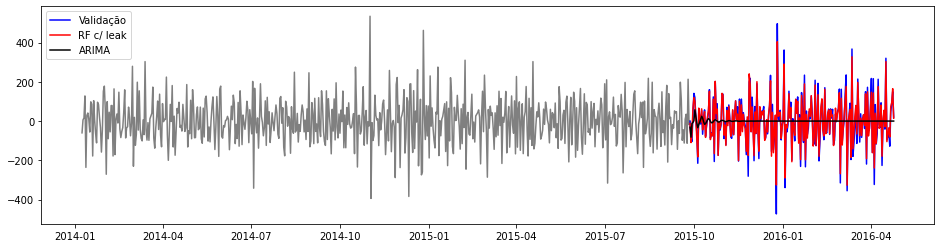

In [59]:
#Resultados
fig, ax = plt.subplots()
ax.plot(train.date, train.diff_sales, color='gray')
ax.plot(test.date, test.diff_sales, color='blue',label='Validação')
ax.plot(test.date, test.pred_RF, color='red',label='RF c/ leak')
ax.plot(test.date, test.pred_ARIMA, color='black',label='ARIMA')

plt.legend()
plt.show()


In [60]:
test.head()

,index,date,dept_id,state_id,cat_id,d,event_name_1,event_type_1,value_sales,sell_price,diff_item1,diff_sales,weekday,Evento_Flag,lag_diff_sales_1,lag_diff_sales_2,lag_diff_sales_3,lag_diff_sales_4,lag_diff_sales_5,lag_diff_sales_6,pred_RF,pred_ARIMA,AE_ARIMA,AE_RF
0,634,2015-09-27,HOBBIES_1,CA,HOBBIES,d_1703,NaN,NaN,553,6.659038,-1.0,-1.0,6,0,17.0,-214.0,112.0,-36.0,-10.0,111.0,-12.06,-31.189583,30.189583,11.06
1,635,2015-09-28,HOBBIES_1,CA,HOBBIES,d_1704,NaN,NaN,466,6.659038,-87.0,-87.0,0,0,-86.0,-69.0,-300.0,26.0,-122.0,-96.0,-109.67,-82.042071,4.957929,22.67
2,636,2015-09-29,HOBBIES_1,CA,HOBBIES,d_1705,NaN,NaN,362,6.659038,-104.0,-104.0,1,0,-17.0,-103.0,-86.0,-317.0,9.0,-139.0,-72.64,-12.459421,91.540579,31.36
3,637,2015-09-30,HOBBIES_1,CA,HOBBIES,d_1706,NaN,NaN,399,6.659038,37.0,37.0,2,0,141.0,124.0,38.0,55.0,-176.0,150.0,65.69,-7.328672,44.328672,28.69
4,638,2015-10-01,HOBBIES_1,CA,HOBBIES,d_1707,NaN,NaN,540,6.659038,141.0,141.0,3,0,104.0,245.0,228.0,142.0,159.0,-72.0,119.10,1.780783,139.219217,21.90


### Ajustando Leak de Curto prazo para um modelo justo de Longo Prazo

In [61]:
#Ajusta

last_7days = train[['weekday', 'lag_diff_sales_1', 'lag_diff_sales_2',
       'lag_diff_sales_3', 'lag_diff_sales_4', 'lag_diff_sales_5',
       'lag_diff_sales_6']].tail(7)

X_test_fix = X_test.drop(['lag_diff_sales_1', 'lag_diff_sales_2',
       'lag_diff_sales_3', 'lag_diff_sales_4', 'lag_diff_sales_5',
       'lag_diff_sales_6'], axis = 1)

train

test_fix = test.drop(['index','lag_diff_sales_1', 'lag_diff_sales_2',
       'lag_diff_sales_3', 'lag_diff_sales_4', 'lag_diff_sales_5',
       'lag_diff_sales_6'],axis =1).merge(last_7days, on = 'weekday', how='inner').sort_values(['date'])

X_test_fix, y_test_fix = test_fix[X_cols], test_fix[y_col]

In [73]:
X_test_fix.sort_values(['weekday'])

,sell_price,weekday,Evento_Flag,lag_diff_sales_1,lag_diff_sales_2,lag_diff_sales_3,lag_diff_sales_4,lag_diff_sales_5,lag_diff_sales_6
57,6.644423,0,0,-68.0,-14.0,-220.0,-310.0,-49.0,-113.0
53,6.665962,0,0,-68.0,-14.0,-220.0,-310.0,-49.0,-113.0
60,6.643942,0,0,-68.0,-14.0,-220.0,-310.0,-49.0,-113.0
36,6.655144,0,0,-68.0,-14.0,-220.0,-310.0,-49.0,-113.0
52,6.669135,0,0,-68.0,-14.0,-220.0,-310.0,-49.0,-113.0
...,...,...,...,...,...,...,...,...,...
22,6.665962,6,0,17.0,-214.0,112.0,-36.0,-10.0,111.0
23,6.644231,6,0,17.0,-214.0,112.0,-36.0,-10.0,111.0
24,6.644423,6,0,17.0,-214.0,112.0,-36.0,-10.0,111.0
26,6.644423,6,1,17.0,-214.0,112.0,-36.0,-10.0,111.0


In [62]:

test['pred_RF_Fix'] = rfr.predict(X_test_fix)
test['AE_RF_Fixed'] = abs(test['pred_RF_Fix'] - test['diff_sales'])
print('Previsão ARIMA teve MAE de {0}, enquanto previsão RF s/ leak teve MAE de {1}'.format(test['AE_ARIMA'].mean(), test['AE_RF_Fixed'].mean()))


Previsão ARIMA teve MAE de 97.45238941882812, enquanto previsão RF s/ leak teve MAE de 119.07658767772513


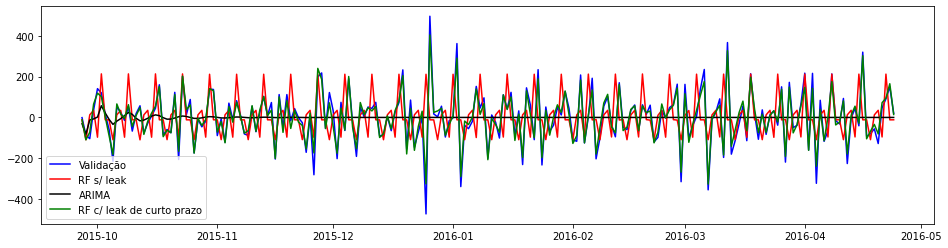

In [82]:
fig, ax = plt.subplots()
#ax.plot(train.date, train.diff_sales, color='gray')
ax.plot(test.date, test.diff_sales, color='blue',label='Validação')97.45238941882812, enquanto previsão RF
ax.plot(test.date, test.pred_RF_Fix, color='red',label='RF s/ leak')
ax.plot(test.date, test.pred_ARIMA, color='black',label='ARIMA')
ax.plot(test.date, test.pred_RF, color='green',label='RF c/ leak de curto prazo')

plt.legend()
plt.show()

In [ ]:
#Outros testes possíveis:
#Normalização das variaveis
#Cruzar lags da RF com phi do ARIMA
#Grid na RF
#fazer mais testes de outros algoritmos 
